In [1]:
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import h5py
import time
np.random.seed(42)

In [2]:
# load MNIST data
opt={"n_h":64,"n_x":784,"lr":0.5,"beta":0.9,"batch_size":64,"epochs":50}
MNIST_data = h5py.File("MNISTdata.hdf5", 'r')
x_train = np.float32(MNIST_data['x_train'][:])
y_train = np.int32(np.array(MNIST_data['y_train'][:, 0])).reshape(-1, 1)
x_test  = np.float32(MNIST_data['x_test'][:])
y_test  = np.int32(np.array(MNIST_data['y_test'][:, 0])).reshape(-1, 1)
MNIST_data.close()


# stack together for next step
X = np.vstack((x_train, x_test))
y = np.vstack((y_train, y_test))


# one-hot encoding
digits = 10
examples = y.shape[0]
y = y.reshape(1, examples)
Y_new = np.eye(digits)[y.astype('int32')]
Y_new = Y_new.T.reshape(digits, examples)


# number of training set
m = 60000
m_test = X.shape[0] - m
X_train, X_test = X[:m].T, X[m:].T
Y_train, Y_test = Y_new[:, :m], Y_new[:, m:]


# shuffle training set
shuffle_index = np.random.permutation(m)
X_train, Y_train = X_train[:, shuffle_index], Y_train[:, shuffle_index]

In [3]:
shuffle_index_feature = np.random.permutation(784)
shuffle_index_feature_inverse=[]
for i in range(784):
    shuffle_index_feature_inverse.append([list(shuffle_index_feature).index(i)])
X_train= X_train[ shuffle_index_feature,:]
X_test= X_test[ shuffle_index_feature,:]
X_train_original= X_train[ shuffle_index_feature_inverse,:]
X_test_original= X_test[ shuffle_index_feature_inverse,:]

7
original


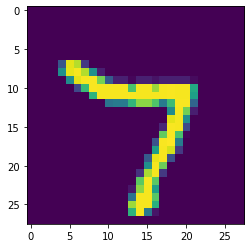

with random flattening


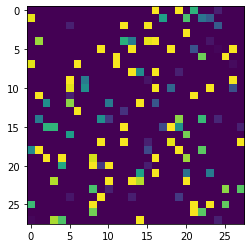

3
original


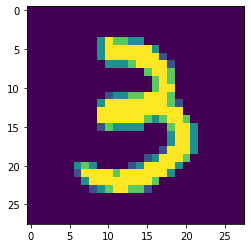

with random flattening


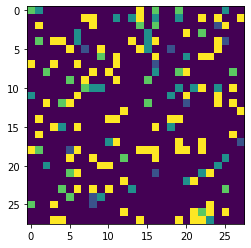

8
original


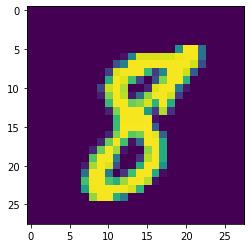

with random flattening


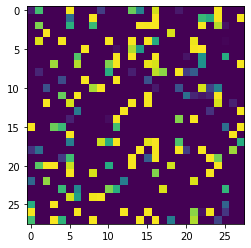

9
original


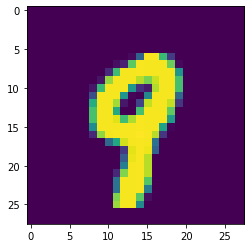

with random flattening


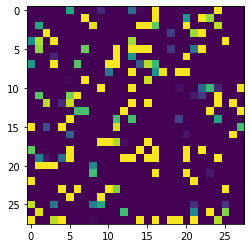

In [4]:
for i in range(4):
    x=Y_train.argmax(axis=0).T[i]
    print(x)
    print("original")
    plt.imshow(X_train_original.T[i].reshape(int(784**0.5),-1))
    plt.show()
    print("with random flattening")
    plt.imshow(X_train.T[i].reshape(int(784**0.5),-1))
    plt.show()

In [5]:
# initialization
params = {"W1": np.random.randn(opt["n_h"], opt["n_x"]) * np.sqrt(1. / opt["n_x"]),
          "b1": np.zeros((opt["n_h"], 1)) * np.sqrt(1. / opt["n_x"]),
          "W2": np.random.randn(digits, opt["n_h"]) * np.sqrt(1. / opt["n_h"]),
          "b2": np.zeros((digits, 1)) * np.sqrt(1. / opt["n_h"])}

In [6]:
def sigmoid(z):
    """
    sigmoid activation function.

    inputs: z
    
    outputs: sigmoid(z)
    """
    s = 1. / (1. + np.exp(-z))
    return s

In [7]:
def compute_loss(Y, Y_hat):
    """
    compute loss function
    """
    L_sum = np.sum(np.multiply(Y, np.log(Y_hat)))
    m = Y.shape[1]
    L = -(1./m) * L_sum

    return L

In [8]:
def feed_forward(X, params):
    """
    feed forward network: 2 - layer neural net

    inputs:
        params: dictionay a dictionary contains all the weights and biases

    return:
        cache: dictionay a dictionary contains all the fully connected units and activations
    """
    cache = {}

    # Z1 = W1.dot(x) + b1
    cache["Z1"] = np.matmul(params["W1"], X) + params["b1"]

    # A1 = sigmoid(Z1)
    cache["A1"] = sigmoid(cache["Z1"])

    # Z2 = W2.dot(A1) + b2
    cache["Z2"] = np.matmul(params["W2"], cache["A1"]) + params["b2"]

    # A2 = softmax(Z2)
    cache["A2"] = np.exp(cache["Z2"]) / np.sum(np.exp(cache["Z2"]), axis=0)

    return cache

In [9]:
def back_propagate(X, Y, params, cache, m_batch):
    """
    back propagation

    inputs:
        params: dictionay a dictionary contains all the weights and biases
        cache: dictionay a dictionary contains all the fully connected units and activations

    return:
        grads: dictionay a dictionary contains the gradients of corresponding weights and biases
    """
    # error at last layer
    dZ2 = cache["A2"] - Y

    # gradients at last layer (Py2 need 1. to transform to float)
    dW2 = (1. / m_batch) * np.matmul(dZ2, cache["A1"].T)
    db2 = (1. / m_batch) * np.sum(dZ2, axis=1, keepdims=True)

    # back propgate through first layer
    dA1 = np.matmul(params["W2"].T, dZ2)
    dZ1 = dA1 * sigmoid(cache["Z1"]) * (1 - sigmoid(cache["Z1"]))

    # gradients at first layer (Py2 need 1. to transform to float)
    dW1 = (1. / m_batch) * np.matmul(dZ1, X.T)
    db1 = (1. / m_batch) * np.sum(dZ1, axis=1, keepdims=True)

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

    return grads


In [10]:
# training
time_i=time.time()
for i in range(opt["epochs"]):

    # shuffle training set
    permutation = np.random.permutation(X_train.shape[1])
    X_train_shuffled = X_train[:, permutation]
    Y_train_shuffled = Y_train[:, permutation]

    for j in range(opt["batch_size"]):

        # get mini-batch
        begin = j * opt["batch_size"]
        end = min(begin + opt["batch_size"], X_train.shape[1] - 1)
        X = X_train_shuffled[:, begin:end]
        Y = Y_train_shuffled[:, begin:end]
        m_batch = end - begin

        # forward and backward
        cache = feed_forward(X, params)
        grads = back_propagate(X, Y, params, cache, m_batch)

        # with momentum (optional)
        grads["dW1"] = (opt["beta"] * grads["dW1"] + (1. - opt["beta"]) * grads["dW1"])
        grads["db1"] = (opt["beta"] * grads["db1"] + (1. - opt["beta"]) * grads["db1"])
        grads["dW2"] = (opt["beta"] * grads["dW2"] + (1. - opt["beta"]) * grads["dW2"])
        grads["db2"] = (opt["beta"] * grads["db2"] + (1. - opt["beta"]) * grads["db2"])

        # gradient descent
        params["W1"] = params["W1"] - opt["lr"] * grads["dW1"]
        params["b1"] = params["b1"] - opt["lr"] * grads["db1"]
        params["W2"] = params["W2"] - opt["lr"] * grads["dW2"]
        params["b2"] = params["b2"] - opt["lr"] * grads["db2"]

    # forward pass on training set
    cache = feed_forward(X_train, params)
    train_loss = compute_loss(Y_train, cache["A2"])

    # forward pass on test set
    cache = feed_forward(X_test, params)
    test_loss = compute_loss(Y_test, cache["A2"])
    print("Epoch {}: training loss = {}, test loss = {}".format(
        i + 1, train_loss, test_loss))
time_f=time.time()

Epoch 1: training loss = 0.8052217427116327, test loss = 0.7838909127429763
Epoch 2: training loss = 0.5455103456551966, test loss = 0.5281705480847119
Epoch 3: training loss = 0.4331385299586229, test loss = 0.41558869190024145
Epoch 4: training loss = 0.38285142039314135, test loss = 0.36579265242668735
Epoch 5: training loss = 0.3660931845906247, test loss = 0.3506511204333983
Epoch 6: training loss = 0.3340238475670567, test loss = 0.3199416641172207
Epoch 7: training loss = 0.3228616282957635, test loss = 0.30562959169495785
Epoch 8: training loss = 0.3079405466425607, test loss = 0.296275425288124
Epoch 9: training loss = 0.3119234566846094, test loss = 0.3025002449647906
Epoch 10: training loss = 0.2889525566063928, test loss = 0.2812675437443611
Epoch 11: training loss = 0.28526150567038167, test loss = 0.277160764372016
Epoch 12: training loss = 0.27031829878893043, test loss = 0.2632899485675788
Epoch 13: training loss = 0.26619205253824657, test loss = 0.25732352745348935
Ep

In [11]:
cache = feed_forward(X_test, params)
Y_pred=cache["A2"]
print(classification_report(y_pred=Y_pred.argmax(axis=0),y_true=Y_test.argmax(axis=0)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.95      0.97      0.96      1032
           3       0.96      0.95      0.95      1010
           4       0.95      0.96      0.95       982
           5       0.93      0.96      0.94       892
           6       0.96      0.95      0.96       958
           7       0.97      0.94      0.95      1028
           8       0.94      0.95      0.95       974
           9       0.95      0.93      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [12]:
print("time of training",time_f-time_i)

time of training 111.95709037780762
